In [24]:
import pandas as pd
from sklearn import preprocessing
import xgboost as xg
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 
import warnings
import numpy as np
import sqlite3
import json
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

warnings.filterwarnings('ignore')

In [25]:
db = sqlite3.connect('predictor_pol/predictor_prod_sin_mails.db', isolation_level=None)
sql = '''
select candidato_elegido as id_candidato
from encuestas;
'''
df = pd.read_sql_query(sql, db)

In [26]:
cand_data = json.loads(open('predictor_pol/candidatos.json','r').read())

In [27]:
def get_party(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return p['party']
    return 'n/a'

def get_name(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return c['name']
    return 'n/a'

In [28]:
df['partido'] = df.id_candidato.apply(get_party)
df['nombre'] = df.id_candidato.apply(get_name)

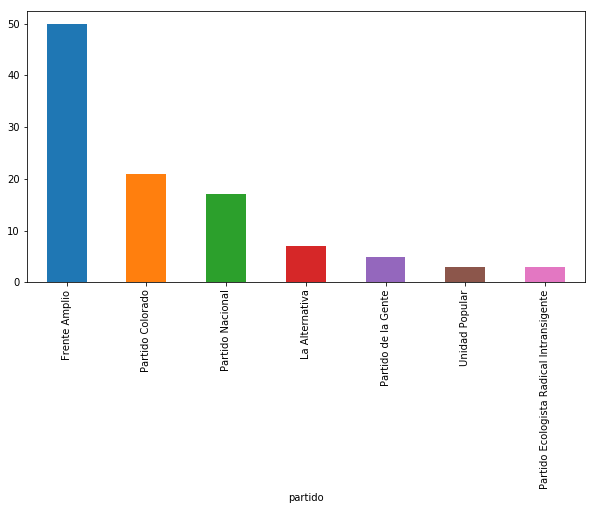

In [29]:
df.groupby('partido').size().sort_values(ascending=False).plot.bar()

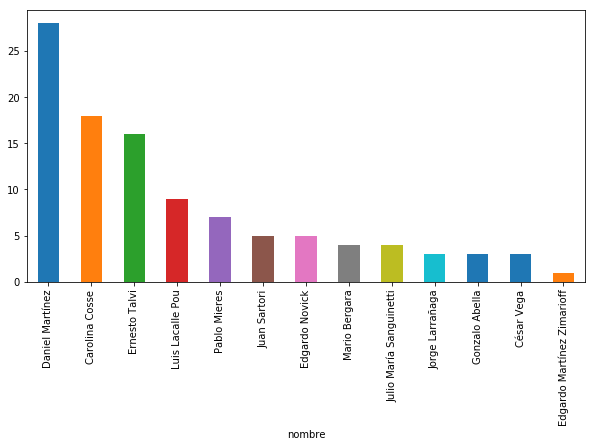

In [30]:
df.groupby('nombre').size().sort_values(ascending=False).plot.bar()

In [9]:
#probando el modelo...
#4,5,candidato1
#3,5,candidato1
#4,3,candidato1
#1,5,candidato2
#2,5,candidato2

In [10]:
data = {'resp1': [4,3,4,1,2], 
        'resp2': [5,5,3,5,5],
        'candidato': ['candidato1','candidato1','candidato1','candidato2','candidato2']}
df = pd.DataFrame.from_dict(data)

In [11]:
df

,candidato,resp1,resp2
0,candidato1,4,5
1,candidato1,3,5
2,candidato1,4,3
3,candidato2,1,5
4,candidato2,2,5


In [12]:
features = ['resp1', 'resp2']
model = xg.XGBClassifier().fit(df[features], df.candidato)

In [13]:
df_test = pd.DataFrame.from_dict({'resp1': [1], 'resp2': [1]})
model.predict(df_test)

array(['candidato1'], dtype=object)